# 5. Neural Networks

In [1]:
%matplotlib inline
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch.optim import Adam
from torch.distributions import Normal
from sklearn.datasets import fetch_mldata, make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import accuracy_score

np.random.seed(1234)
# device = 'cuda' if torch.cuda.is_available() else 'cpu'

## 5.1 Feed-forward Network Functions

In [2]:
class RegressionNetwork(nn.Module):
    def __init__(self, *ndims):
        super(RegressionNetwork, self).__init__()
        # should be module list
        self.layers = nn.ModuleList()
        for i in range(len(ndims)-1):
            self.layers.append(nn.Linear(ndims[i], ndims[i+1]))
    
    def forward(self, x):
        for l in self.layers:
            x = torch.tanh(l(x))
        return x

In [3]:
def create_toy_data(func, n=50):
    x = torch.linspace(-1, 1, n)[:, None]
    return x, func(x)

def sinusoidal(x):
    return torch.sin(np.pi * x)

def heaviside(x):
    return 0.5 * (torch.sign(x) + 1)

In [4]:
x, y = create_toy_data(sinusoidal)
model = RegressionNetwork(1, 10, 1)

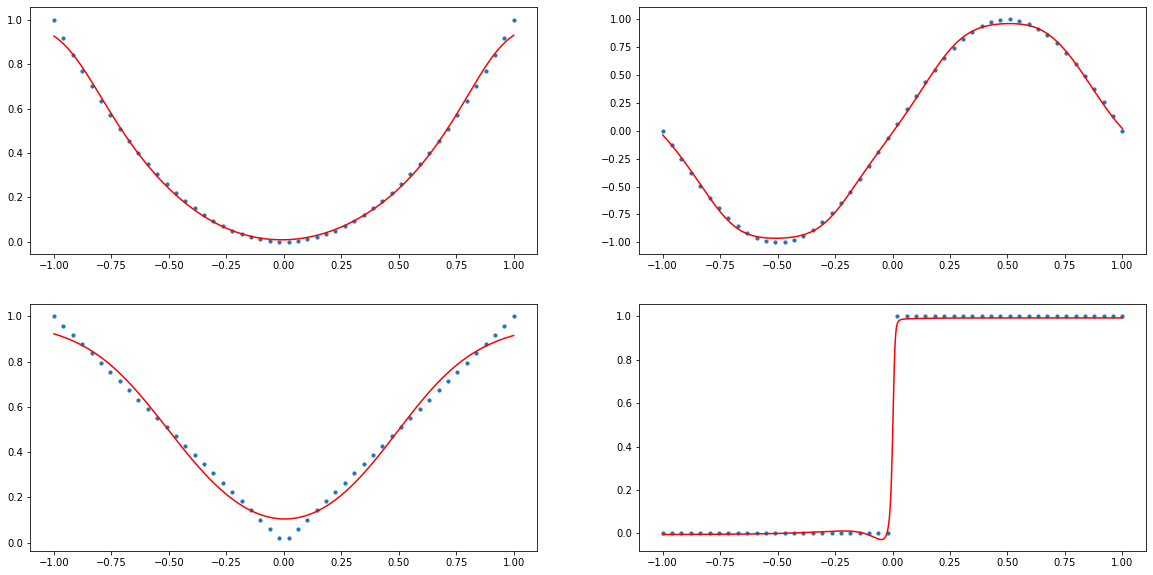

In [5]:
func_list = [np.square, sinusoidal, np.abs, heaviside]
plt.figure(figsize=(20, 10))
x = torch.linspace(-1, 1, 1000)[:, None]
x.require_grads=False

loss_fn = nn.MSELoss()
for i, func, n_iter in zip(range(1, 5), func_list, [1000, 1000, 1000, 1000]):
    plt.subplot(2, 2, i)
    x_train, y_train = create_toy_data(func)
    model = RegressionNetwork(1, 5, 5, 5, 5, 1)
    optimizer = Adam(model.parameters(), lr=0.01)
    for _ in range(n_iter):
        optimizer.zero_grad()
        loss = loss_fn(model(x_train), y_train)
        loss.backward()
        optimizer.step()
    y = model(x)
    plt.scatter(x_train.numpy(), y_train.numpy(), s=10)
    # y need to be detach here, otherwise with grads cannot be converted to numpy()
    plt.plot(x.numpy(), y.detach().numpy(), color="r")
plt.show()

## 5.3 Error Backpropagation

In [6]:
class ClassificationNetwork(nn.Module): 
    def __init__(self, n_input, n_hidden, n_output):
        # the first argument of super must be type, here it is just the class name.
        super(ClassificationNetwork, self).__init__()
        self.fc1 = nn.Linear(n_input, n_hidden)
        self.fc2 = nn.Linear(n_hidden, n_output)

    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        return torch.sigmoid(self.fc2(x))

In [7]:
torch.rand(10)*2-1

tensor([ 0.1022,  0.3707,  0.1509, -0.0868,  0.9312,  0.1804,  0.7672, -0.3003,
         0.0754, -0.9055])

In [5]:
def create_toy_data():
    # torch.rand return uniform number in [0, 1], this returns number between -1 and 1
    x = torch.rand(size=(100, 2)) * 2 - 1
    labels = torch.prod(x, dim=1) > 0
    return x, labels.reshape(-1, 1).float()
x_train, y_train = create_toy_data()

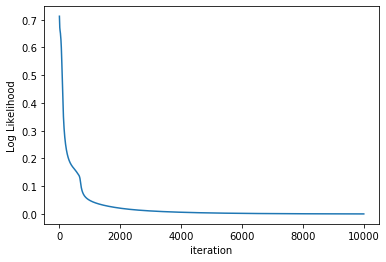

In [9]:
model = ClassificationNetwork(2, 4, 1)
optimizer = Adam(model.parameters(), lr=1e-2)
history = []
# loss_fn = nn.CrossEntropyLoss()
loss_fn = nn.BCELoss()
for i in range(10000):
    loss = loss_fn(model(x_train), y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    logit = model(x_train)
    history.append(loss.item())

plt.plot(history)
plt.xlabel("iteration")
plt.ylabel("Log Likelihood")
plt.show()

In [10]:
x = np.random.randint(1, 10, (2, 2, 4)); x

array([[[4, 7, 6, 5],
        [9, 2, 8, 7]],

       [[9, 1, 6, 1],
        [7, 3, 1, 6]]])

In [11]:
x.reshape(2, -1)

array([[4, 7, 6, 5, 9, 2, 8, 7],
       [9, 1, 6, 1, 7, 3, 1, 6]])

In [12]:
x = np.array([[1, 2], [3, 4], [5, 6]])
x.reshape(2, -1)

array([[1, 2, 3],
       [4, 5, 6]])

In [13]:
next(model.parameters()).is_cuda

False

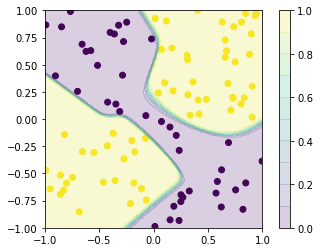

In [14]:
x0, x1 = np.meshgrid(np.linspace(-1, 1, 100), np.linspace(-1, 1, 100))
x = np.array([x0, x1]).reshape(2, -1).T
x = torch.from_numpy(x).float()
y = model(x).view(100, 100).detach().numpy()
levels = np.linspace(0, 1, 11)
plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train.detach().numpy().ravel())
plt.contourf(x0, x1, y, levels, alpha=0.2)
plt.colorbar()
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.gca().set_aspect('equal')
plt.show()

## 5.5 Regularization in Neural Networks

In [15]:
norm = torch.distributions.Normal(loc=0, scale=0.25)
def create_toy_data(n=10):
    x = torch.linspace(0, 1, n)[:, None]
    return x, torch.sin(2 * np.pi * x) + norm.sample((n, 1))

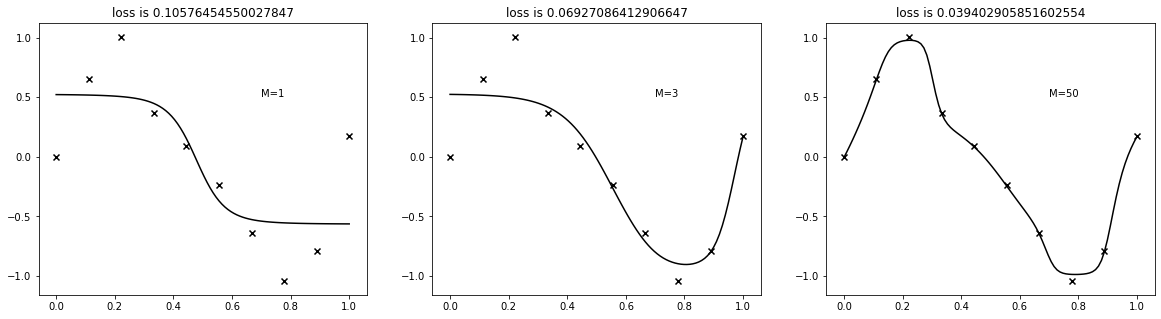

In [16]:
loss_fn = nn.MSELoss()
x_train, y_train = create_toy_data()
x = torch.linspace(0, 1, 100)[:, None]
plt.figure(figsize=(20, 5))
for i, m in enumerate([1, 3, 50]):
    plt.subplot(1, 3, i + 1)
    model = RegressionNetwork(1, m, m, 1)
    optimizer = Adam(model.parameters(), 0.01)
    for j in range(1000):
        loss = loss_fn(model(x_train), y_train)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    y = model(x)
    plt.title(f"loss is {loss_fn(y, torch.sin(2 * np.pi * x))}")
    plt.scatter(x_train.numpy().ravel(), y_train.numpy().ravel(), marker="x", color="k")
    plt.plot(x.numpy().ravel(), y.detach().numpy().ravel(), color="k")
    plt.annotate("M={}".format(m), (0.7, 0.5))
plt.show()

In [6]:
class RegularizedRegressionNetwork(nn.Module):
    def __init__(self, *ndims):
        super().__init__()
        self.layers = nn.ModuleList()
        for i in range(len(ndims)-1):
            self.layers.append(nn.Linear(ndims[i], ndims[i+1]))
        self.prior = Normal(0, 1)

    def __call__(self, x):
        for l in self.layers[:-1]:
            x = torch.tanh(l(x))
        return self.layers[-1](x)
    
    def log_prior(self):
        logp = 0
        for param in self.parameters():
            logp += self.prior.log_prob(param).sum()
        return logp

In [7]:
loss_fn = nn.MSELoss()
for i, weight_decay in enumerate([0, 0.01, 0.1]):
    model = RegularizedRegressionNetwork(1, 50, 1)
    optimizer = Adam(model.parameters(), lr=0.1, weight_decay=weight_decay)
    for i in range(1000):
        pred = model(x_train)
        loss = loss_fn(model(x_train), y_train)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    y = model(x).detach().numpy()
    plt.figure()
    plt.scatter(x_train, y_train, marker="x", color="k")
    plt.plot(x, y, color="k")
    plt.annotate(f"M=50", (0.7, 0.5))
    plt.title(f"weight decay {weight_decay}")

RuntimeError: size mismatch, m1: [100 x 2], m2: [1 x 50] at /opt/conda/conda-bld/pytorch_1565932117561/work/aten/src/TH/generic/THTensorMath.cpp:707

In [ ]:
MNIST_URL='http://deeplearning.net/data/mnist/mnist.pkl'
from fastai import datasets
def get_data():
    path = datasets.download_data(MNIST_URL, ext='.gz')
    with gzip.open(path, 'rb') as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')
    return map(tensor, (x_train,y_train,x_valid,y_valid))

In [ ]:
x_train, y_train, x_valid, y_valid = get_data()

In [ ]:
x, y = mnist.data, mnist.target

In [ ]:
x.shape, y.shape

In [ ]:
def get_data():
    path = dataset.download_data(MNIST_URL, ext='.gz')
    with gzip.open(path, 'rb') as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')
    return map(tensor, (x_train,y_train,x_valid,y_valid))
x_train, x_test, y_train, label_test = get_data()

In [ ]:
x_train.shape

In [ ]:
class ConvolutionalNeuralNetwork(nn.Network):
    
    def __init__(self):
        super().__init__()
        with self.set_parameter():
            self.conv1 = nn.image.Convolve2d(
                nn.random.truncnormal(-2, 2, 1, (5, 5, 1, 20)),
                stride=(1, 1), pad=(0, 0))
            self.b1 = nn.array([0.1] * 20)
            self.conv2 = nn.image.Convolve2d(
                nn.random.truncnormal(-2, 2, 1, (5, 5, 20, 20)),
                stride=(1, 1), pad=(0, 0))
            self.b2 = nn.array([0.1] * 20)
            self.w3 = nn.random.truncnormal(-2, 2, 1, (4 * 4 * 20, 100))
            self.b3 = nn.array([0.1] * 100)
            self.w4 = nn.random.truncnormal(-2, 2, 1, (100, 10))
            self.b4 = nn.array([0.1] * 10)
        
    def __call__(self, x):
        h = nn.relu(self.conv1(x) + self.b1)
        h = nn.max_pooling2d(h, (2, 2), (2, 2))        
        h = nn.relu(self.conv2(h) + self.b2)
        h = nn.max_pooling2d(h, (2, 2), (2, 2))
        h = h.reshape(-1, 4 * 4 * 20)
        h = nn.relu(h @ self.w3 + self.b3)
        return h @ self.w4 + self.b4

model = ConvolutionalNeuralNetwork()
optimizer = nn.optimizer.Adam(model.parameter, 1e-3)

while True:
    indices = np.random.permutation(len(x_train))
    for index in range(0, len(x_train), 50):
        model.clear()
        x_batch = x_train[indices[index: index + 50]]
        y_batch = y_train[indices[index: index + 50]]
        logit = model(x_batch)
        log_likelihood = -nn.loss.softmax_cross_entropy(logit, y_batch).mean(0).sum()
        if optimizer.iter_count % 100 == 0:
            accuracy = accuracy_score(
                np.argmax(y_batch, axis=-1), np.argmax(logit.value, axis=-1)
            )
            print("step {:04d}".format(optimizer.iter_count), end=", ")
            print("accuracy {:.2f}".format(accuracy), end=", ")
            print("Log Likelihood {:g}".format(log_likelihood.value[0]))
        optimizer.maximize(log_likelihood)
        if optimizer.iter_count == 1000:
            break
    else:
        continue
    break

In [ ]:
print("accuracy (test):", accuracy_score(np.argmax(model(x_test).value, axis=-1), label_test))

## 5.6 Mixture Density Networks

In [ ]:
def create_toy_data(func, n=300):
    t = np.random.uniform(size=(n, 1))
    x = func(t) + np.random.uniform(-0.05, 0.05, size=(n, 1))
    return x, t

def func(x):
        return x + 0.3 * np.sin(2 * np.pi * x)

def sample(x, t, n=None):
    assert len(x) == len(t)
    N = len(x)
    if n is None:
        n = N
    indices = np.random.choice(N, n, replace=False)
    return x[indices], t[indices]

x_train, y_train = create_toy_data(func)

In [ ]:
class MixtureDensityNetwork(nn.Network):
    
    def __init__(self, n_input, n_hidden, n_components):
        self.n_components = n_components
        super().__init__()
        with self.set_parameter():
            self.w1 = nn.random.truncnormal(-2, 2, 1, (n_input, n_hidden))
            self.b1 = nn.zeros(n_hidden)
            self.w2c = nn.random.truncnormal(-2, 2, 1, (n_hidden, n_components))
            self.b2c = nn.zeros(n_components)
            self.w2m = nn.random.truncnormal(-2, 2, 1, (n_hidden, n_components))
            self.b2m = nn.zeros(n_components)
            self.w2s = nn.random.truncnormal(-2, 2, 1, (n_hidden, n_components))
            self.b2s = nn.zeros(n_components)

    def __call__(self, x):
        h = nn.tanh(x @ self.w1 + self.b1)
        coef = nn.softmax(h @ self.w2c + self.b2c)
        mean = h @ self.w2m + self.b2m
        std = nn.exp(h @ self.w2s + self.b2s)
        return coef, mean, std
    
def gaussian_mixture_pdf(x, coef, mu, std):
    gauss = (
        nn.exp(-0.5 * nn.square((x - mu) / std))
        / std / np.sqrt(2 * np.pi)
    )
    return (coef * gauss).sum(axis=-1)

In [ ]:
model = MixtureDensityNetwork(1, 5, 3)
optimizer = nn.optimizer.Adam(model.parameter, 1e-4)

for i in range(30000):
    model.clear()
    coef, mean, std = model(x_train)
    log_likelihood = nn.log(gaussian_mixture_pdf(y_train, coef, mean, std)).sum()
    optimizer.maximize(log_likelihood)

In [ ]:
x = np.linspace(x_train.min(), x_train.max(), 100)[:, None]
y = np.linspace(y_train.min(), y_train.max(), 100)[:, None, None]
coef, mean, std = model(x)

plt.figure(figsize=(20, 15))
plt.subplot(2, 2, 1)
plt.plot(x[:, 0], coef.value[:, 0], color="blue")
plt.plot(x[:, 0], coef.value[:, 1], color="red")
plt.plot(x[:, 0], coef.value[:, 2], color="green")
plt.title("weights")

plt.subplot(2, 2, 2)
plt.plot(x[:, 0], mean.value[:, 0], color="blue")
plt.plot(x[:, 0], mean.value[:, 1], color="red")
plt.plot(x[:, 0], mean.value[:, 2], color="green")
plt.title("means")

plt.subplot(2, 2, 3)
proba = gaussian_mixture_pdf(y, coef, mean, std).value
levels_log = np.linspace(0, np.log(proba.max()), 21)
levels = np.exp(levels_log)
levels[0] = 0
xx, yy = np.meshgrid(x.ravel(), y.ravel())
plt.contour(xx, yy, proba.reshape(100, 100), levels)
plt.xlim(x_train.min(), x_train.max())
plt.ylim(y_train.min(), y_train.max())

plt.subplot(2, 2, 4)
argmax = np.argmax(coef.value, axis=1)
for i in range(3):
    indices = np.where(argmax == i)[0]
    plt.plot(x[indices, 0], mean.value[(indices, np.zeros_like(indices) + i)], color="r", linewidth=2)
plt.scatter(x_train, y_train, facecolor="none", edgecolor="b")
plt.show()

## 5.7 Bayesian Neural Networks

In [ ]:
x_train, y_train = make_moons(n_samples=500, noise=0.2)
y_train = y_train[:, None]

In [ ]:
class Gaussian(nn.Network):

    def __init__(self, shape):
        super().__init__()
        with self.set_parameter():
            self.m = nn.zeros(shape)
            self.s = nn.zeros(shape)

    def __call__(self):
        self.q = nn.Gaussian(self.m, nn.softplus(self.s) + 1e-8)
        return self.q.draw()


class BayesianNetwork(nn.Network):
    
    def __init__(self, n_input, n_hidden, n_output=1):
        super().__init__()
        with self.set_parameter():
            self.qw1 = Gaussian((n_input, n_hidden))
            self.qb1 = Gaussian(n_hidden)
            self.qw2 = Gaussian((n_hidden, n_hidden))
            self.qb2 = Gaussian(n_hidden)
            self.qw3 = Gaussian((n_hidden, n_output))
            self.qb3 = Gaussian(n_output)
        self.posterior = [self.qw1, self.qb1, self.qw2, self.qb2, self.qw3, self.qb3]
        self.prior = nn.Gaussian(0, 1)

    def __call__(self, x):
        h = nn.tanh(x @ self.qw1() + self.qb1())
        h = nn.tanh(h @ self.qw2() + self.qb2())
        return nn.Bernoulli(logit=h @ self.qw3() + self.qb3())
    
    def kl(self):
        kl = 0
        for pos in self.posterior:
            kl += nn.loss.kl_divergence(pos.q, self.prior).mean()
        return kl

In [ ]:
model = BayesianNetwork(2, 5, 1)
optimizer = nn.optimizer.Adam(model.parameter, 0.1)
for i in range(1, 2001, 1):
    model.clear()
    py = model(x_train)
    elbo = py.log_pdf(y_train).mean(0).sum() - model.kl() / len(x_train)
    optimizer.maximize(elbo)
    if i % 100 == 0:
        optimizer.learning_rate *= 0.9

In [ ]:
x_grid = np.mgrid[-2:3:100j, -2:3:100j]
x1, x2 = x_grid[0], x_grid[1]
x_grid = x_grid.reshape(2, -1).T

y = np.mean([model(x_grid).mean.value.reshape(100, 100) for _ in range(10)], axis=0)

plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train.ravel(), s=5)
plt.contourf(x1, x2, y, np.linspace(0, 1, 11), alpha=0.2)
plt.colorbar()
plt.xlim(-2, 3)
plt.ylim(-2, 3)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()